### Get OpenStreetMap Features
* Map features: https://wiki.openstreetmap.org/wiki/Map_features

In [1]:
# Packages
import osmnx as ox
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import hvplot.pandas
import geoviews as gv
from shapely.geometry import box

In [2]:
# Functions
def buffer_aoi(gdf_aoi, buffer=1000):
    # Reproject to EPSG:3857
    crs = gdf_aoi.crs
    gdf_aoi = gdf_aoi.to_crs('EPSG:3857')

    # Buffer area of interest
    gdf_aoi['geometry'] = gdf_aoi.buffer(buffer)

    # Reproject back to original crs
    gdf_aoi = gdf_aoi.to_crs(crs)
    
    # Return buffered aoi
    return gdf_aoi

def features_from_aoi(gdf_aoi, tags, clip='false'):
    # Get bounds
    bounds = gdf_aoi.total_bounds

    # Get features from bbox
    try:
        gdf_features = ox.features_from_bbox(bounds, tags)
    except ox._errors.InsufficientResponseError:
        gdf_features = gpd.GeoDataFrame(columns=['geometry'], crs=gdf_aoi.crs)
    
    # Clip features to bbox
    if clip == 'aoi':
        gdf_features = gdf_features.clip(gdf_aoi)
    if clip == 'box':
        gdf_features = gdf_features.cx[bounds[0]:bounds[2], bounds[1]:bounds[3]]
        
    # Return features
    return gdf_features

In [3]:
# Define geographic area of interest
geocode_aoi = "Rotterdam, Netherlands"
#geocode_aoi = "Amsterdam, Netherlands"
#geocode_aoi = "London, United Kingdom"
#geocode_aoi = "Berlin, Germany"
#geocode_aoi = "Munich, Germany"
#geocode_aoi = "Istanbul, Turkey"

# Get area of interest
gdf_aoi = ox.geocode_to_gdf(geocode_aoi)

# Buffer area of interest
gdf_buffer = buffer_aoi(gdf_aoi, buffer=1000)

# Get bounds
bounds = gdf_buffer.total_bounds
xlim = (bounds[0], bounds[2])
ylim = (bounds[1], bounds[3])

# Get districts
gdf_districts = features_from_aoi(gdf_buffer, tags={"boundary": "administrative", "admin_level": "9"})
gdf_districts = gdf_districts.clip(gdf_aoi)
import numpy as np
gdf_districts = gdf_districts[np.logical_or(gdf_districts.geom_type == "Polygon", gdf_districts.geom_type == "MultiPolygon")]



# Get train lines
gdf_train_lines = features_from_aoi(gdf_buffer, tags={"railway": "rail"})
if "usage"  in gdf_train_lines.columns:
    gdf_train_lines = gdf_train_lines[gdf_train_lines["usage"].isin(["main", "branch"])]

# Get metro lines
gdf_metro_lines = features_from_aoi(gdf_buffer, tags={"railway": "subway"})
if "service" in gdf_metro_lines.columns:
    gdf_metro_lines = gdf_metro_lines[~gdf_metro_lines["service"].isin(["yard", "siding", "spur", "crossover"])]

# Get light rail lines
gdf_light_rail_lines = features_from_aoi(gdf_buffer, tags={"railway": "light_rail"})

# Get tram lines
gdf_tram_lines = features_from_aoi(gdf_buffer, tags={"railway": "tram"})
#if "service" in gdf_tram_lines.columns:
#    gdf_tram_lines = gdf_tram_lines[~gdf_tram_lines["service"].isin(["yard", "siding", "spur", "crossover"])]

# Get train, metro, light rail stations
gdf_stations = features_from_aoi(gdf_buffer, tags={"railway": "station"})
gdf_stations["geometry"] = gdf_stations["geometry"].map(lambda x: x.centroid if x.geom_type != "Point" and x.geom_type != "MultiPoint" else x)
if "station" in gdf_stations.columns:
    gdf_train_stations = gdf_stations[~gdf_stations["station"].isin(["subway", "light_rail"])]
    gdf_metro_stations = gdf_stations[gdf_stations["station"].isin(["subway"])]
    gdf_light_rail_stations = gdf_stations[gdf_stations["station"].isin(["light_rail"])]
    gdf_tram_stations = gdf_stations[gdf_stations["station"].isin(["tram"])]

# Get tram stations
gdf_tram_stations = features_from_aoi(gdf_buffer, tags={"railway": "tram_stop"})
gdf_tram_stations["geometry"] = gdf_tram_stations["geometry"].map(lambda x: x.centroid if x.geom_type != "Point" else x)

# Remove museum tramstation amsterdam
#gdf_tram_stations = gdf_tram_stations[gdf_tram_stations["wikidata"].notna()] 

In [4]:
gdf_districts

geometry  \
element  id                                                            
relation 1411101   POLYGON ((4.37933 51.96341, 4.37936 51.96341, ...   
         11932429  MULTIPOLYGON (((4.41505 51.94953, 4.41824 51.9...   
         11931705  POLYGON ((4.39701 51.89708, 4.3976 51.89717, 4...   
         324431    POLYGON ((4.39701 51.89708, 4.3976 51.89717, 4...   
         47772     POLYGON ((4.37933 51.96341, 4.37936 51.96341, ...   

                  admin_level authoritative bag:bronwoonplaats  \
element  id                                                      
relation 1411101           10           yes                NaN   
         11932429         NaN           NaN                NaN   
         11931705         NaN           NaN                NaN   
         324431             8           yes                NaN   
         47772              4           NaN                NaN   

                         boundary source           start_date turn:lanes  \
element  id                                                                
relation 1411101   administrative    BAG  2020-02-27 00:00:01        NaN   
         11932429  administrative    NaN           2005-01-01        NaN   
         11931705  administrative    NaN           2005-01-01        NaN   
         324431    administrative    NaN                  NaN        NaN   
         47772     administrative    NaN                 1840        NaN   

                                                                note alt_name  \
element  id                                                                     
relation 1411101                                                 NaN      NaN   
         11932429  Geen admin_level, want waterschappen staan los...      NaN   
         11931705  Geen admin_level, want waterschappen staan los...      NaN   
         324431                                                  NaN      NaN   
         47772                                                   NaN      NaN   

                   ... ref:gemeentecode name:carnaval    name:el   name:mk  \
element  id        ...                                                       
relation 1411101   ...              NaN           NaN  Ρότερνταμ  Ротердам   
         11932429  ...              NaN           NaN        NaN       NaN   
         11931705  ...              NaN           NaN        NaN       NaN   
         324431    ...             0599           NaN  Ρότερνταμ       NaN   
         47772     ...              NaN           NaN        NaN       NaN   

                  alt_ref                            description  \
element  id                                                        
relation 1411101      NaN                                    NaN   
         11932429     NaN  waterschap, bestuurslaag in Nederland   
         11931705     NaN  waterschap, bestuurslaag in Nederland   
         324431       NaN                                    NaN   
         47772        NaN                                    NaN   

                  ref:waterschapscode                      short_name  \
element  id                                                             
relation 1411101                  NaN                             NaN   
         11932429                0656  Schieland en de Krimpenerwaard   
         11931705                0655                 Hollandse Delta   
         324431                   NaN                             NaN   
         47772                    NaN                             NaN   

                                                       website short_ref  
element  id                                                               
relation 1411101                                           NaN       NaN  
         11932429  https://www.schielandendekrimpenerwaard.nl/       NaN  
         11931705                         https://www.wshd.nl/       WHD  
         324431                                            NaN       NaN  
     

In [5]:
# Keep name and geometry
gdf_aoi = gdf_aoi[["name", "geometry"]].reset_index(drop=True)
gdf_buffer = gdf_buffer[["name", "geometry"]].reset_index(drop=True)
gdf_districts = gdf_districts[["name", "geometry"]].reset_index(drop=True)
gdf_train_stations = gdf_train_stations[["name", "geometry"]].reset_index(drop=True)
gdf_metro_stations = gdf_metro_stations[["name", "geometry"]].reset_index(drop=True)
gdf_light_rail_stations = gdf_light_rail_stations[["name", "geometry"]].reset_index(drop=True)
gdf_tram_stations = gdf_tram_stations[["name", "geometry"]].reset_index(drop=True)
gdf_train_lines = gdf_train_lines[["name", "geometry"]].reset_index(drop=True)
gdf_metro_lines = gdf_metro_lines[["name", "geometry"]].reset_index(drop=True)
gdf_light_rail_lines = gdf_light_rail_lines[["name", "geometry"]].reset_index(drop=True)
gdf_tram_lines = gdf_tram_lines[["name", "geometry"]].reset_index(drop=True)

C:\Users\Ruben\AppData\Local\Temp\ipykernel_15064\1227110324.py:26: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


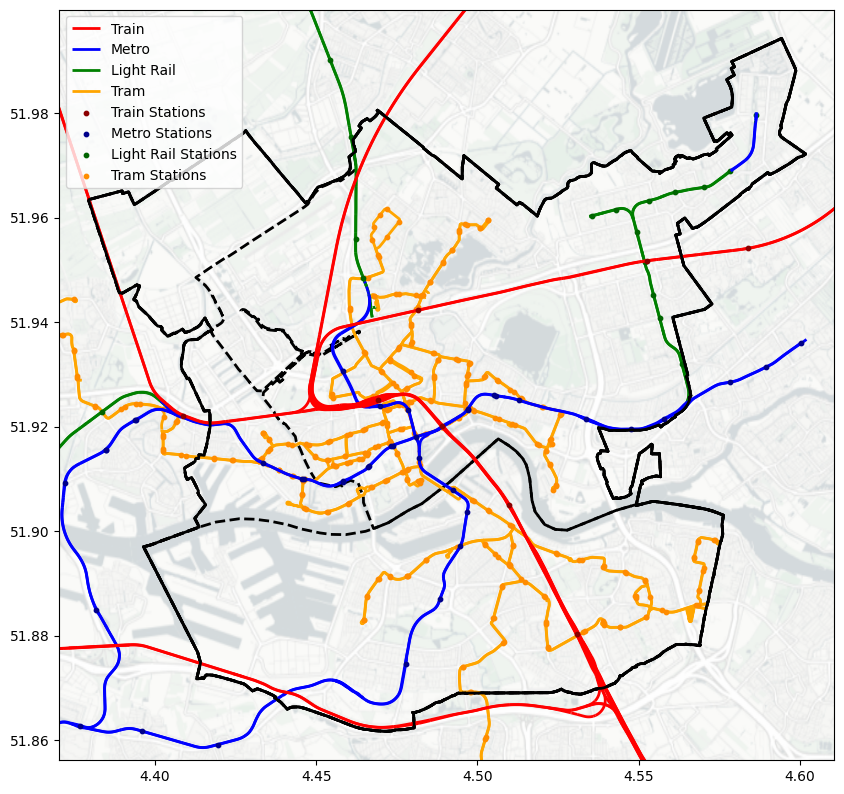

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf_aoi.plot(ax=ax, facecolor='none', edgecolor="black", linewidth=2, label="Area of Intrest", zorder=3)
gdf_districts.plot(ax=ax, facecolor='none', edgecolor="black", linewidth=2, linestyle='--', label="Districts", zorder=1)

if not gdf_train_stations.empty:
    gdf_train_lines.plot(ax=ax, color="red", linewidth=2, label="Train", zorder=1.4)
if not gdf_metro_lines.empty:
    gdf_metro_lines.plot(ax=ax, color="blue", linewidth=2, label="Metro", zorder=1.3)
if not gdf_light_rail_lines.empty:
    gdf_light_rail_lines.plot(ax=ax, color="green", linewidth=2, label="Light Rail", zorder=1.2)
if not gdf_tram_lines.empty:
    gdf_tram_lines.plot(ax=ax, color="orange", linewidth=2, label="Tram", zorder=1.1)

if not gdf_train_stations.empty:
    gdf_train_stations.plot(ax=ax, color="darkred", markersize=10, label="Train Stations", zorder=1.4)
if not gdf_metro_stations.empty:
    gdf_metro_stations.plot(ax=ax, color="darkblue", markersize=10, label="Metro Stations", zorder=1.3)
if not gdf_light_rail_stations.empty:
    gdf_light_rail_stations.plot(ax=ax, color="darkgreen", markersize=10, label="Light Rail Stations", zorder=1.2)
if not gdf_tram_stations.empty:
    gdf_tram_stations.plot(ax=ax, color="darkorange", markersize=10, label="Tram Stations", zorder=1.1)

ax.set_xlim(xlim)
ax.set_ylim(ylim)
cx.add_basemap(ax, crs=gdf_train_lines.crs, source=cx.providers.CartoDB.PositronNoLabels, attribution=False)
ax.legend()
plt.show()

In [7]:
# Plot all lines and stations
plot_map = gv.tile_sources.CartoLight
plot_aoi = gdf_aoi.hvplot(geo=True, line_width=2, line_color="black", fill_color="none")
plot_districts = gdf_districts.hvplot(geo=True, line_width=2, line_color="black", line_dash="dashed", fill_color="none")

plot_train_lines = gdf_train_lines.hvplot(geo=True, line_width=2, line_color="red")
plot_metro_lines = gdf_metro_lines.hvplot(geo=True, line_width=2, line_color="blue")
plot_light_rail_lines = gdf_light_rail_lines.hvplot(geo=True, line_width=2, line_color="green")
plot_tram_lines = gdf_tram_lines.hvplot(geo=True, line_width=2, line_color="orange")

plot_train_stations = gdf_train_stations.hvplot(geo=True, color="darkred", size=20)
plot_metro_stations = gdf_metro_stations.hvplot(geo=True, color="darkblue", size=20)
plot_light_rail_stations = gdf_light_rail_stations.hvplot(geo=True, color="darkgreen", size=20)
plot_tram_stations = gdf_tram_stations.hvplot(geo=True, color="darkorange", size=20)

(plot_map * plot_tram_lines * plot_tram_stations * plot_light_rail_lines * plot_light_rail_stations *
 plot_metro_lines * plot_metro_stations * plot_train_lines * plot_train_stations * plot_aoi).opts(width=800, height=800)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Path.I     :Path   [Longitude,Latitude]
   .Points.I   :Points   [Longitude,Latitude]
   .Path.II    :Path   [Longitude,Latitude]
   .Points.II  :Points   [Longitude,Latitude]
   .Path.III   :Path   [Longitude,Latitude]
   .Points.III :Points   [Longitude,Latitude]
   .Path.IV    :Path   [Longitude,Latitude]
   .Points.IV  :Points   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

In [8]:
# Write geojsons
gdf_aoi.to_file("aoi.geojson", driver="GeoJSON")
gdf_districts.to_file("districts.geojson", driver="GeoJSON")
gdf_train_lines.to_file("train_lines.geojson", driver="GeoJSON")
gdf_metro_lines.to_file("metro_lines.geojson", driver="GeoJSON")
gdf_light_rail_lines.to_file("light_rail_lines.geojson", driver="GeoJSON")
gdf_tram_lines.to_file("tram_lines.geojson", driver="GeoJSON")
gdf_train_stations.to_file("train_stations.geojson", driver="GeoJSON")
gdf_metro_stations.to_file("metro_stations.geojson", driver="GeoJSON")
gdf_light_rail_stations.to_file("light_rail_stations.geojson", driver="GeoJSON")
gdf_tram_stations.to_file("tram_stations.geojson", driver="GeoJSON")